# Preparation & Data Understanding

## Importing and Unzipping Datasets

In [1]:
from google.colab import drive
import os

# Mount to google Drive
drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/BCC_Freepass_DS'

# Check the folder
if os.path.exists(project_path):
  print("Folder found!")
  print(os.listdir(project_path))
else:
  print("Folder not found.")

Mounted at /content/drive
Folder found!
['Datasets_Freepass.zip']


In [2]:
import zipfile

# Extract and create a temporary folder for colab
zip_path = os.path.join(project_path, 'Datasets_Freepass.zip')
extract_path = '/content/dataset'

if not os.path.exists(extract_path):
  print("Extracting files..")
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
  print("Extraction Successful!")
else:
  print("Folder already exists.")


Extracting files..
Extraction Successful!


### Data Exploration

In [3]:
import os

# Path to annotations
annot_path = '/content/dataset/train/annotations'

# Check if the folder exists & reads the first 5 files
if os.path.exists(annot_path):
  files = os.listdir(annot_path)
  files.sort()
  print(f"Found {len(files)} files in annotions")
  print("First 5 files:", files[:5])

  # Check file format
  if len(files) > 0:
    first_file = files[0]
    with open(os.path.join(annot_path, first_file)) as f:
      content = f.read()

  print(f"\nFirst file: {first_file}")
  print(f"File format: {content}")

else:
  print(f"{annot_path} is not found.")

Found 2208 files in annotions
First 5 files: ['2015_00001.png.txt', '2015_00004.jpg.txt', '2015_00006.jpg.txt', '2015_00010.jpg.txt', '2015_00013.jpg.txt']

First file: 2015_00001.png.txt
File format: % bbGt version=3
Bicycle 204 28 271 193 0 0 0 0 0 0 0



### Coordination Visualization and Verification

File opened: /content/dataset/train/images/2015_00001.png
Detection: Bicycle in x=204.0, y=28.0, w=271.0, h=193.0


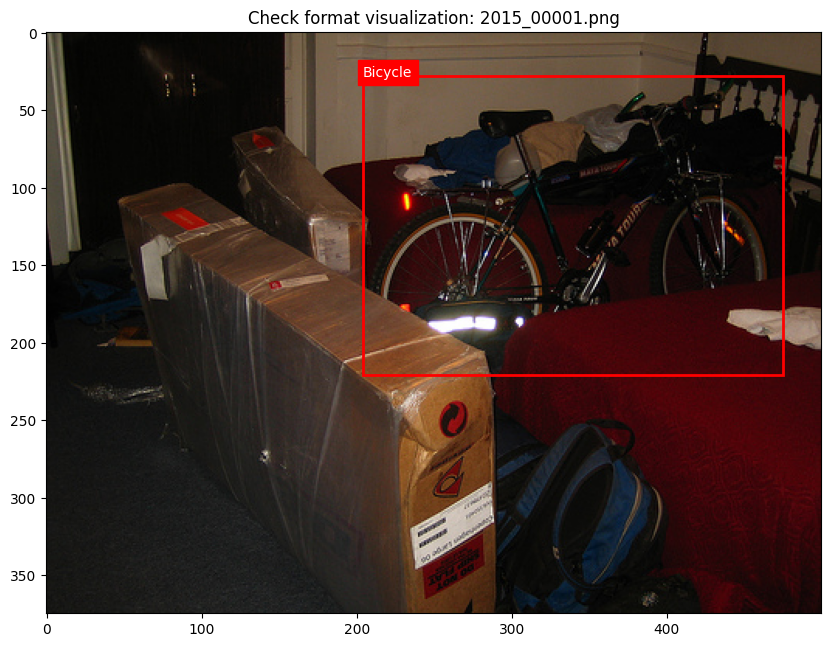

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

# Setup path
img_filename = '2015_00001.png'
txt_filename = '2015_00001.png.txt'

img_path = os.path.join('/content/dataset/train/images', img_filename)
txt_path = os.path.join('/content/dataset/train/annotations', txt_filename)

# Check and read the image
if not os.path.exists(img_path):
  # Change .png to .jpg if needed
  img_path = img_path.replace('.png', '.jpg')

print(f"File opened: {img_path}")
im = Image.open(img_path)

# Setup plotting, 1 canvas with 10x10 inches
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(im)

# Read the coordinate & draw the square
with open(txt_path, 'r') as f:
  lines = f.readlines()

  for line in lines:
    if line.startswith('%'): continue # Lewati header

    parts = line.strip().split()
    label = parts[0]

    # Hipotesis format caltech adalah [x_min, y_min, width, height]
    x = float(parts[1])
    y = float(parts[2])
    w = float(parts[3])
    h = float(parts[4])

    print(f"Detection: {label} in x={x}, y={y}, w={w}, h={h}")

    # Make a red rectangular
    rect = patches.Rectangle(
        (x, y), w, h,
        linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
    ax.text(x, y, label, color='white', backgroundcolor='red')

  plt.title(f"Check format visualization: {img_filename}")
  plt.show()


# Preprocessing

### Format Conversion

In [5]:
import os
from tqdm import tqdm # Loading bar

annot_path = '/content/dataset/train/annotations'
unique_labels = set()

print("Scanning thousands of files...")

# Looping all files
files = os.listdir(annot_path)
for filename in tqdm(files):
  if not filename.endswith('.txt'): continue

  with open(os.path.join(annot_path, filename), 'r') as f:
    lines = f.readlines()
    for line in lines:
      if line.startswith('%'): continue # Skip header

      parts = line.strip().split()
      if len(parts) > 0:
        label = parts[0]
        unique_labels.add(label)

print("\n\nSCAN RESULTS")
print(f"Total label found: {len(unique_labels)}")
print(f"Label list: {unique_labels}")

Scanning thousands of files...


100%|██████████| 2208/2208 [00:00<00:00, 33366.44it/s]



SCAN RESULTS
Total label found: 12
Label list: {'Car', 'Cat', 'Chair', 'Cup', 'Dog', 'Bottle', 'Motorbike', 'Bicycle', 'People', 'Table', 'Bus', 'Boat'}


### Convert to YOLO Format

In [6]:
import os
import shutil
import random
from PIL import Image
from tqdm import tqdm

# CONFIGURATION
# Define classes (Sorted alphabetically for consistency)
class_list = sorted(['Motorbike', 'Cat', 'People', 'Boat', 'Cup', 'Table',
                     'Chair', 'Car', 'Bottle', 'Bicycle', 'Bus', 'Dog'])

# Create a dictionary mapping: {'Bicycle': 0, 'Boat': 1, ...}
class_map = {name: i for i, name in enumerate(class_list)}
print(f"Class Mapping: {class_map}")

# Setup paths
base_path = '/content/yolo_dataset' # Target folder for YOLO
src_img_path = '/content/dataset/train/images'
src_lbl_path = '/content/dataset/train/annotations'

# PREPARATION
# Clean up previous run to ensure a fresh start
if os.path.exists(base_path):
    print("Removing existing YOLO folder to avoid conflicts...")
    shutil.rmtree(base_path)

# Create directory structure: train/images, train/labels, val/images, val/labels
dirs = ['train', 'val']
subdirs = ['images', 'labels']

for d in dirs:
    for s in subdirs:
        os.makedirs(os.path.join(base_path, d, s), exist_ok=True)

# DATA SPLITTING
# Get all image files
all_files = [f for f in os.listdir(src_img_path) if f.endswith(('.jpg', '.png'))]

# Shuffle files for random distribution
random.seed(42) # Fixed seed for reproducibility
random.shuffle(all_files)

# Split 80% Training, 20% Validation
split_idx = int(len(all_files) * 0.8)
train_files = all_files[:split_idx]
val_files = all_files[split_idx:]

print(f"Total Images: {len(all_files)}")
print(f"Training Set: {len(train_files)}")
print(f"Validation Set: {len(val_files)}")

# CONVERSION LOGIC
def convert_and_move(files, split_name):
    print(f"Processing {split_name} data...")

    for filename in tqdm(files):
        # Copy Image
        src_img = os.path.join(src_img_path, filename)
        dst_img = os.path.join(base_path, split_name, 'images', filename)
        shutil.copy(src_img, dst_img)

        # Get Image Dimensions (Required for Normalization)
        with Image.open(src_img) as im:
            img_w, img_h = im.size

        # Process Annotation
        # Corresponding annotation file: image.png -> image.png.txt
        txt_name = filename + ".txt"
        src_txt = os.path.join(src_lbl_path, txt_name)

        yolo_lines = []
        if os.path.exists(src_txt):
            with open(src_txt, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    if line.startswith('%'): continue # Skip header

                    parts = line.strip().split()
                    label_text = parts[0]

                    if label_text in class_map:
                        class_id = class_map[label_text]

                        # Raw Coordinates (x_min, y_min, w, h)
                        x_min = float(parts[1])
                        y_min = float(parts[2])
                        w_rect = float(parts[3])
                        h_rect = float(parts[4])

                        # Calculate Center Coordinates
                        x_center = x_min + (w_rect / 2)
                        y_center = y_min + (h_rect / 2)

                        # Normalize to 0-1 range (YOLO format)
                        x_norm = x_center / img_w
                        y_norm = y_center / img_h
                        w_norm = w_rect / img_w
                        h_norm = h_rect / img_h

                        # Format: class_id x_center y_center width height
                        # .6f means 6 decimal places precision
                        yolo_line = f"{class_id} {x_norm:.6f} {y_norm:.6f} {w_norm:.6f} {h_norm:.6f}"
                        yolo_lines.append(yolo_line)

        # Save New Annotation
        # Remove original extension from filename for the label file
        # e.g., image.png -> image.txt (Standard YOLO naming)
        save_name = os.path.splitext(filename)[0] + ".txt"
        dst_txt = os.path.join(base_path, split_name, 'labels', save_name)

        with open(dst_txt, 'w') as f:
            f.write("\n".join(yolo_lines))

# EXECUTION
convert_and_move(train_files, 'train')
convert_and_move(val_files, 'val')

print("\nSUCCESS! YOLO dataset is ready at: /content/yolo_dataset")

Class Mapping: {'Bicycle': 0, 'Boat': 1, 'Bottle': 2, 'Bus': 3, 'Car': 4, 'Cat': 5, 'Chair': 6, 'Cup': 7, 'Dog': 8, 'Motorbike': 9, 'People': 10, 'Table': 11}
Total Images: 2027
Training Set: 1621
Validation Set: 406
Processing train data...


100%|██████████| 1621/1621 [00:00<00:00, 2013.64it/s]


Processing val data...


100%|██████████| 406/406 [00:00<00:00, 1984.12it/s]


SUCCESS! YOLO dataset is ready at: /content/yolo_dataset


### Verify YOLO Format Conversion

In [17]:
import os
import random

# Define path to the training labels
label_path = '/content/yolo_dataset/train/labels'

# Select one random file from the directory to inspect
random_file = random.choice(os.listdir(label_path))

print(f"Inspecting file: {random_file}")
print("--- FILE CONTENT START ---")

# Open and read the file content
with open(os.path.join(label_path, random_file), 'r') as f:
    print(f.read())

print("--- FILE CONTENT END ---")

Inspecting file: 2015_05933.txt
--- FILE CONTENT START ---
10 0.939560 0.807692 0.092622 0.374690
10 0.386970 0.781638 0.127159 0.377171
10 0.233909 0.764268 0.097331 0.263027
10 0.134223 0.694789 0.045526 0.094293
10 0.173469 0.712159 0.042386 0.084367
9 0.368917 0.846154 0.185243 0.272953
4 0.656201 0.831266 0.401884 0.317618
4 0.114600 0.846154 0.213501 0.277916
10 0.551805 0.718362 0.042386 0.136476
--- FILE CONTENT END ---


### YOLOv8 Installation

In [18]:
# 1. INSTALLATION
# Grab the YOLOv8 library (ultralytics).
# The '-q' flag keeps the output clean so it doesn't flood our screen.
!pip install ultralytics -q

import yaml
import os

print("Installation done! Now let's create the config file...")

# 2. CONFIGURATION (The Blueprint)
# We need to tell YOLO where to find the data and what the classes are.
# Think of this as the "Rulebook" for the training session.
yolo_config = {
    'path': '/content/yolo_dataset',  # The root folder we created in Step 5
    'train': 'train/images',          # Where the study materials are
    'val': 'val/images',              # Where the exam materials are

    # Class names map (Must match the IDs we generated earlier!)
    'names': {
        0: 'Bicycle', 1: 'Boat', 2: 'Bottle', 3: 'Bus',
        4: 'Car', 5: 'Cat', 6: 'Chair', 7: 'Cup',
        8: 'Dog', 9: 'Motorbike', 10: 'People', 11: 'Table'
    }
}

# 3. SAVING THE FILE
# Write this configuration to a 'dataset.yaml' file.
# YOLO will read this file later to know what to do.
yaml_path = '/content/dataset.yaml'

with open(yaml_path, 'w') as f:
    yaml.dump(yolo_config, f, sort_keys=False)

print(f"SUCCESS! Config file saved at: {yaml_path}")

# Quick verify: Let's peek at the file content to make sure it looks right.
print("\n--- YAML CONTENT PREVIEW ---")
with open(yaml_path, 'r') as f:
    print(f.read())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.2 MB/s eta 0:00:00
Installation done! Now let's create the config file...
SUCCESS! Config file saved at: /content/dataset.yaml

--- YAML CONTENT PREVIEW ---
path: /content/yolo_dataset
train: train/images
val: val/images
names:
  0: Bicycle
  1: Boat
  2: Bottle
  3: Bus
  4: Car
  5: Cat
  6: Chair
  7: Cup
  8: Dog
  9: Motorbike
  10: People
  11: Table



# Training

In [ ]:
from ultralytics import YOLO

# 1. LOAD MODEL
# We use 'yolov8n.pt' (Nano version).
# It's the smallest and fastest model, perfect for free Colab and learning.
print("Loading the brain (YOLOv8 Nano)...")
model = YOLO('yolov8n.pt')

# 2. START TRAINING
# - data: The map we made in Step 6
# - epochs: How many times the AI studies the whole book (30 rounds is a good start)
# - imgsz: Image size (640 is standard)
# - batch: How many images to look at at once (16 is safe for Colab RAM)
print("Training started! Grab a coffee, this will take a while...")

results = model.train(
    data='/content/dataset.yaml',
    epochs=30,
    imgsz=640,
    batch=16,
    name='my_custom_yolo' # Name of the result folder
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Loading the brain (YOLOv8 Nano)...
Training started! Grab a coffee, this will take a while...
Ultralytics 8.4.11 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (AMD EPYC 7B12)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0,